In [24]:
#Step1: Importing the necessary file
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import matplotlib.ticker as ticker

In [25]:
#Step2: Construct a sample dataset
mapping_data = {
    'Trait': ['Trait1', 'Trait1', 'Trait2', 'Trait2'],
    'Causal_Gene': ['GeneA', 'GeneA', 'GeneB', 'GeneB'],
    'Non_Causal_Gene': ['GeneX', 'GeneY', 'GeneZ', 'GeneW'],
    'Status': ['Causal', 'Non-Causal', 'Causal', 'Non-Causal']
}

# Create a DataFrame using the dictionary
trait_gene_df = pd.DataFrame(mapping_data)

# Export DataFrame to a CSV file
trait_gene_df.to_csv('trait_gene_mapping.csv', index=False)

# Print the resulting DataFrame
print("Trait-Gene Mapping Table:")
print(trait_gene_df)

Trait-Gene Mapping Table:
    Trait Causal_Gene Non_Causal_Gene      Status
0  Trait1       GeneA           GeneX      Causal
1  Trait1       GeneA           GeneY  Non-Causal
2  Trait2       GeneB           GeneZ      Causal
3  Trait2       GeneB           GeneW  Non-Causal


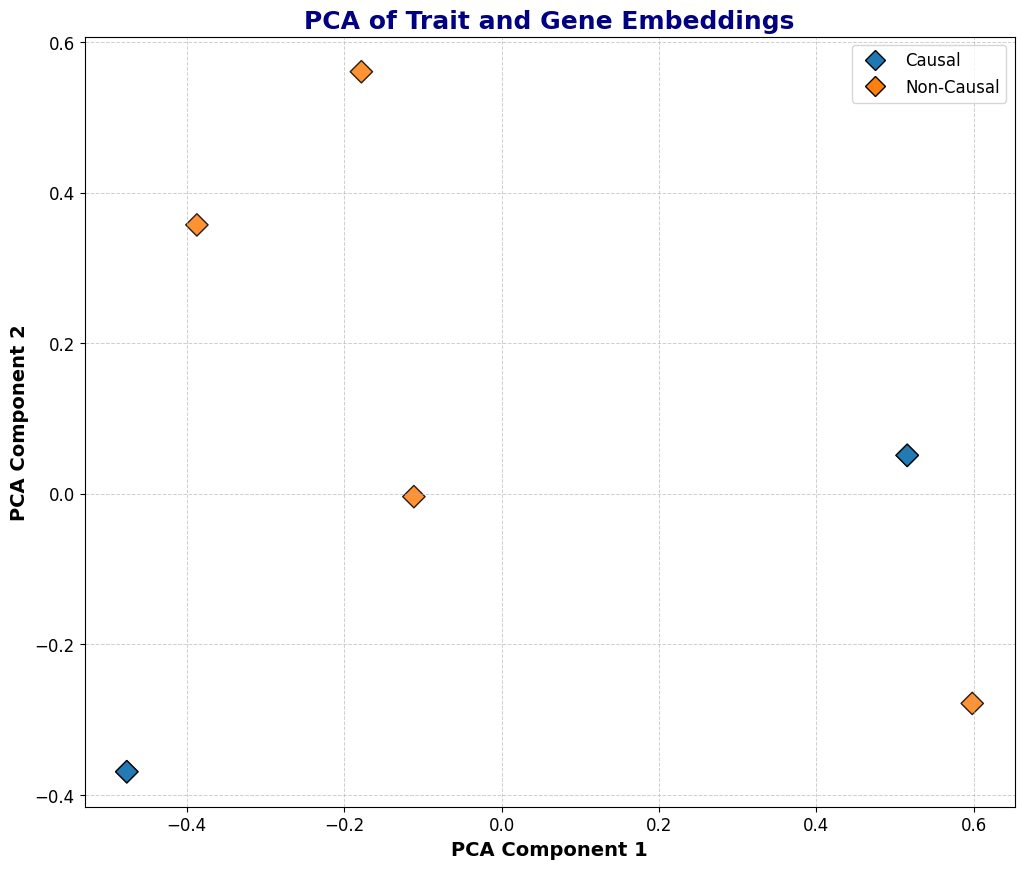

In [26]:
# Step 3: Create Random Embeddings for Genes
unique_gene_count = len(trait_gene_df['Causal_Gene'].unique()) + len(trait_gene_df['Non_Causal_Gene'].unique())
np.random.seed(42)  # Seed for reproducibility

# Generate random embeddings for causal and non-causal genes
gene_list = trait_gene_df['Causal_Gene'].unique().tolist() + trait_gene_df['Non_Causal_Gene'].unique().tolist()
gene_embedding_matrix = np.random.rand(unique_gene_count, 5)  # 5-dimensional embeddings
gene_embeddings_df = pd.DataFrame(gene_embedding_matrix, index=gene_list)

# Step 4: Prepare Data for PCA
trait_gene_embedding_data = []

for _, row in trait_gene_df.iterrows():
    causal_embedding = gene_embeddings_df.loc[row['Causal_Gene']].values
    non_causal_embedding = gene_embeddings_df.loc[row['Non_Causal_Gene']].values

    trait_gene_embedding_data.append((row['Trait'], row['Causal_Gene'], causal_embedding, 'Causal'))
    trait_gene_embedding_data.append((row['Trait'], row['Non_Causal_Gene'], non_causal_embedding, 'Non-Causal'))

# Step 5: Format Data for PCA
pca_input_data = []

for trait, gene, embedding, label in trait_gene_embedding_data:
    pca_input_data.append([trait, gene] + embedding.tolist() + [label])

# Construct a DataFrame for PCA
columns = ['Trait', 'Gene'] + [f'Embedding_{i+1}' for i in range(5)] + ['Status']
pca_dataframe = pd.DataFrame(pca_input_data, columns=columns)

# Step 6: Apply PCA for Dimensionality Reduction
embeddings_for_pca = pca_dataframe.iloc[:, 2:-1].values  # Extract embeddings for PCA
labels = pca_dataframe['Status']

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_for_pca)


# Step 7: Plot the PCA results with customized styling
plt.figure(figsize=(12, 10))  # Increase the figure size for clarity
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
            c=labels.map({'Causal': '#1f77b4', 'Non-Causal': '#ff7f0e'}),  # Custom color codes
            s=130,  # Larger marker size for emphasis
            edgecolor='black',  # Add a black border around the points for distinctiveness
            alpha=0.85,  # Slightly increase opacity for clearer visuals
            marker='D')  # Change marker style to diamond ('D')

plt.title('PCA of Trait and Gene Embeddings', fontsize=18, weight='bold', color='navy')  # Bold title with color
plt.xlabel('PCA Component 1', fontsize=14, weight='bold')
plt.ylabel('PCA Component 2', fontsize=14, weight='bold')

# Customize the ticks and grid style
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.6)  # Custom grid style with dashed lines

# Customize the legend, manually placing and styling it
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='D', color='w', markerfacecolor='#1f77b4', markeredgecolor='black', markersize=10, label='Causal'),
                   Line2D([0], [0], marker='D', color='w', markerfacecolor='#ff7f0e', markeredgecolor='black', markersize=10, label='Non-Causal')]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12)

# Show the plot with customized settings
plt.show()

In [27]:
# Step 8: Prepare Data for Vector Analysis
vector_diff_data = []

for _, row in trait_gene_df.iterrows():
    causal_vector = gene_embeddings_df.loc[row['Causal_Gene']].values
    non_causal_vector = gene_embeddings_df.loc[row['Non_Causal_Gene']].values

    # Compute the difference between the causal and non-causal gene embeddings
    diff_vector = causal_vector - non_causal_vector
    vector_diff_data.append([row['Trait'], row['Causal_Gene'], row['Non_Causal_Gene'], diff_vector.tolist()])

# Step 9: Create a DataFrame for Vector Analysis
diff_vector_df = pd.DataFrame(vector_diff_data, columns=['Trait', 'Causal_Gene', 'Non_Causal_Gene', 'Difference_Vector'])

# Step 10: Print the Vector Analysis Data
print("\nVector Analysis Results:")
print(diff_vector_df)



Vector Analysis Results:
    Trait Causal_Gene Non_Causal_Gene  \
0  Trait1       GeneA           GeneX   
1  Trait1       GeneA           GeneY   
2  Trait2       GeneB           GeneZ   
3  Trait2       GeneB           GeneW   

                                   Difference_Vector  
0  [0.35395562455156004, -0.019195545752078158, -...  
1  [0.19113560899392867, 0.6464720634503784, 0.20...  
2  [-0.4558583743861768, -0.08141024848384237, 0....  
3  [-0.629181441056811, -0.14159016999016028, 0.3...  


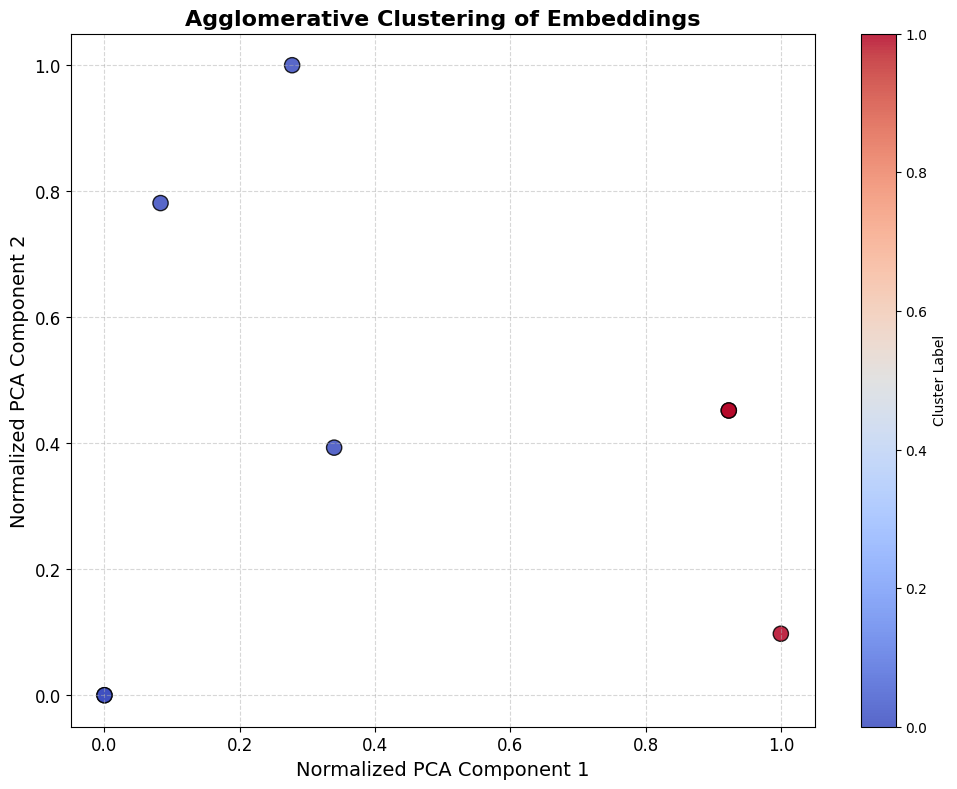

Unique Cluster Groups Assigned:
[0 1]


In [28]:
# Step 11: Scale the reduced embeddings for better visualization
scaler = MinMaxScaler()
scaled_embeddings = scaler.fit_transform(reduced_embeddings)

# Step 12: Apply Agglomerative Clustering
agg_cluster_model = AgglomerativeClustering(n_clusters=2)
cluster_assignments = agg_cluster_model.fit_predict(scaled_embeddings)

# Step 13: Visualize the clustering results with distinct styling
plt.figure(figsize=(12, 9))  # Increase figure size
plt.scatter(scaled_embeddings[:, 0], scaled_embeddings[:, 1],
            c=cluster_assignments, cmap='coolwarm', s=120, edgecolors='black', alpha=0.85, marker='o')  # Style and size changes

plt.title('Agglomerative Clustering of Embeddings', fontsize=16, weight='bold')
plt.xlabel('Normalized PCA Component 1', fontsize=14)
plt.ylabel('Normalized PCA Component 2', fontsize=14)

# Customize ticks for better clarity
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.2))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(label='Cluster Label', orientation='vertical')
plt.show()

# Step 14: Print unique cluster labels
print("Unique Cluster Groups Assigned:")
print(np.unique(cluster_assignments))
